<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Критерии оценки:** *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#импортируем библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import random
import re
import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from yellowbrick.classifier import ConfusionMatrix

In [2]:
try:
    
    data = pd.read_csv('toxic_comments.csv', index_col=0)

except:

    data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)   

In [3]:
#выведем первые 5 строк датафрейма
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
#выведем основную информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проверим, что положительный класс (1) - это токсичные комментарии:

In [5]:
data.query('toxic==1')

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...
159374,"""\n\n our previous conversation \n\nyou fuckin...",1
159394,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159421,Your absurd edits \n\nYour absurd edits on gre...,1
159426,"""\n\nHey listen don't you ever!!!! Delete my e...",1


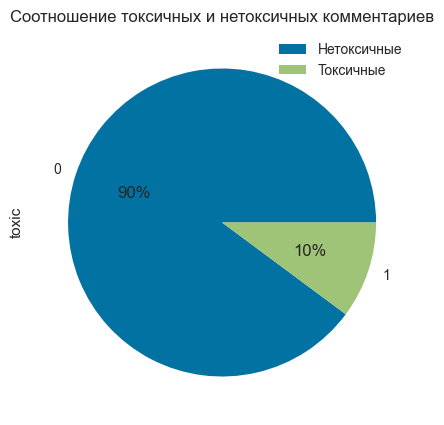

In [6]:
#посмотрим на дисбаланс классов
ax = data['toxic'].value_counts().\
plot(kind='pie', figsize=(5,5), autopct='%.0f%%')

plt.title('Соотношение токсичных и нетоксичных комментариев')
plt.legend(['Нетоксичные', 'Токсичные']); 

Количество нетоксичных комментариев в 9 раз превышает токсичные.

Очистим текст и проведем лемматизацию:

In [7]:
def clean_text(text):
    re_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    re_text = re_text.split()
    re_text = " ".join(re_text)
    return re_text

In [8]:
data['clean_text']= data['text'].apply(lambda x: clean_text(x))

In [9]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    lemm_text = " ".join(lemm_list)
    return lemm_text

In [11]:
tqdm.pandas()
data['lemm_text'] = data['clean_text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [18:58<00:00, 139.95it/s]  


In [12]:
data.sample(5)

,text,toxic,clean_text,lemm_text
116761,IP \n\nNote that I use endless IP numbers.,0,IP Note that I use endless IP numbers,IP Note that I use endless IP number
47164,Wow can we say dense....,0,Wow can we say dense,Wow can we say dense
139008,It appears that you have some financial or oth...,0,It appears that you have some financial or oth...,It appear that you have some financial or othe...
7306,"Sorry, missed the ping, commented there now.",0,Sorry missed the ping commented there now,Sorry miss the ping comment there now
111982,"""\n""""Local government in Wales consists of 22 ...",0,Local government in Wales consists of unitary ...,Local government in Wales consists of unitary ...


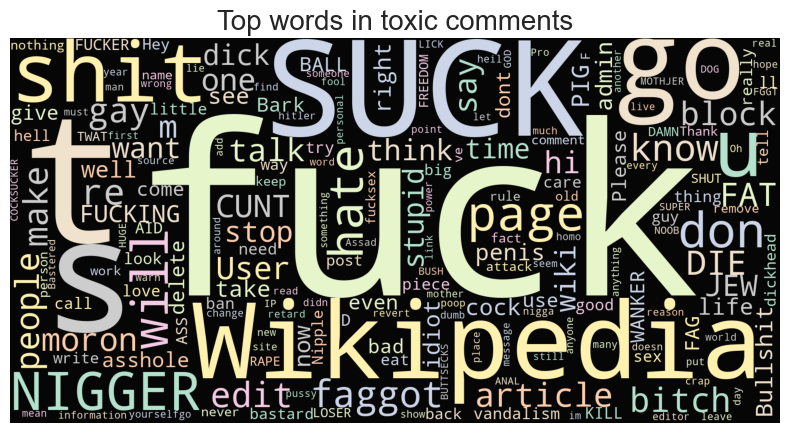

In [13]:
#посмотрим на частоиспользуемые слова в токсичных комментариях
data_toxic = data.drop(['text', 'clean_text'], axis=1).query('toxic==1')
plt.figure(figsize=(10, 5))
wc = WordCloud(background_color="black", 
                stopwords=STOPWORDS,width=1600, height=800, collocations=False)
wc.generate(" ".join(data_toxic.lemm_text))
plt.title("Top words in toxic comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Pastel2', random_state=17), alpha=0.98)
plt.axis('off');

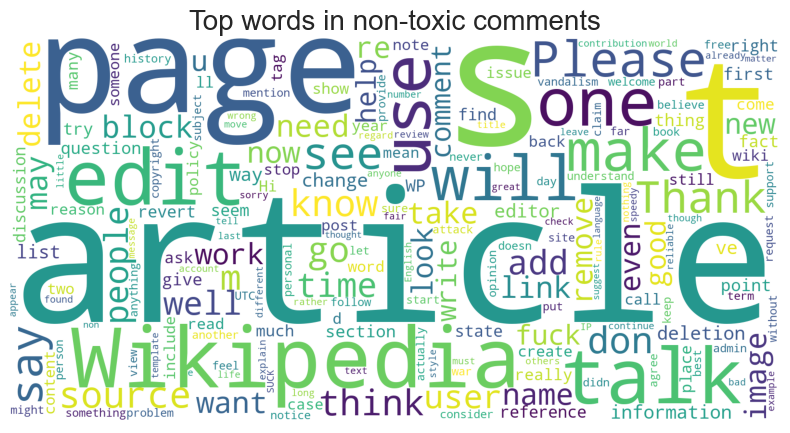

In [14]:
#посмотрим на частоиспользуемые слова в нетоксичных комментариях
plt.figure(figsize=(10, 5))
wc = WordCloud(background_color="white", stopwords=STOPWORDS, width=1600, height=800,collocations=False)
wc.generate(" ".join(data.lemm_text))
plt.title("Top words in non-toxic comments", fontsize=20)
plt.imshow(wc.recolor(random_state=17), alpha=0.98)
plt.axis('off');

***Вывод:***

На данном этапе мы:
- выявили дисбаланс классов 
- провели очистку и лемматизацию текста


## Обучение

### Разделение на выборки

In [15]:
#выделим признаки
features = data['lemm_text']
target = data['toxic']

In [16]:
#выделим 75% для обучающей выборки
features_train, features_test, target_train,target_test = \
train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

In [17]:
#выведем размеры, полученных таблиц
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(119469,)
(119469,)
(39823,)
(39823,)


In [18]:
#посмотрим на дисбаланс на обучающей выборке
target_train.value_counts(normalize=True)

0    0.898384
1    0.101616
Name: toxic, dtype: float64

### Обучение моделей

Для борьбы с дисбалансом (так как нам важно прогнозирование положительного класса (тоскичные комментарии = 1) будем делать веса классов сбалансированными.

#### LogisticRegression

In [21]:
random.seed(42)

In [22]:
%%time

#подбор параметров для логистической регрессии с помощью GridSearch
pipe_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english")),
                ('clf', LogisticRegression(class_weight='balanced'))])

grid_params_lr = {'tfidf__ngram_range': ((1, 1), (1, 2)),
    'clf__C': range(9,10)}
grid_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='f1') 
grid_lr.fit(features_train, target_train)

print(grid_lr.best_estimator_)
print(grid_lr.best_params_)
print(grid_lr.best_score_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', LogisticRegression(C=9, class_weight='balanced'))])
{'clf__C': 9, 'tfidf__ngram_range': (1, 2)}
0.7771562862582636
CPU times: user 8min 53s, sys: 6min 57s, total: 15min 51s
Wall time: 3min 6s


#### LGBMClassifier

In [23]:
%%time

#подбор параметров для LGBM с помощью GridSearch
pipe_gbm = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english")),
                ('clf', LGBMClassifier(objective="binary", is_unbalance=True))])

grid_params_gbm = {'tfidf__ngram_range': ((1, 1), (1, 2)),
    'clf__n_estimators': range(200, 601, 200)
                  }
grid_gbm = GridSearchCV(estimator=pipe_gbm,
            param_grid=grid_params_gbm,
            scoring='f1') 
grid_gbm.fit(features_train, target_train)

print(grid_gbm.best_estimator_)
print(grid_gbm.best_params_)
print(grid_gbm.best_score_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf',
                 LGBMClassifier(is_unbalance=True, n_estimators=600,
                                objective='binary'))])
{'clf__n_estimators': 600, 'tfidf__ngram_range': (1, 2)}
0.7589752900817407
CPU times: user 1h 32min 43s, sys: 13min 48s, total: 1h 46min 32s
Wall time: 2h 20min 47s


In [24]:
#сравним результаты
result = {'model_name':\
['LogisticRegression','LGBMClassifier'],\
'F1_grid': [grid_lr.best_score_, grid_gbm.best_score_]}
result = pd.DataFrame(result)
result.\
sort_values(by='F1_grid', ascending = False).\
reset_index(drop = True)

,model_name,F1_grid
0,LogisticRegression,0.777156
1,LGBMClassifier,0.758975


## Тестирование модели

In [25]:
%%time

#лучшая модель логистической регрессии
test_pred_lr = grid_lr.best_estimator_.predict(features_test)
result_test_lr = f1_score(target_test, test_pred_lr) 
print('F1 лучшей модели на тестовой выборке:', result_test_lr)

F1 лучшей модели на тестовой выборке: 0.782661339145175
CPU times: user 1.78 s, sys: 341 ms, total: 2.12 s
Wall time: 1.83 s


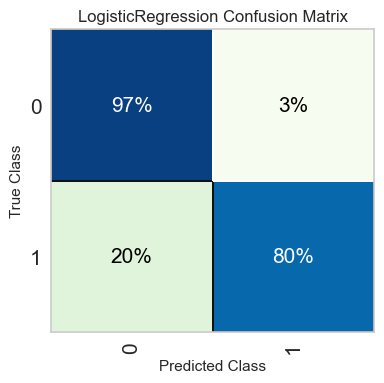

In [26]:
#посмотрим на матрицу ошибок лучшей модели логистической регрессии
cm = ConfusionMatrix(grid_lr.best_estimator_, percent=True, classes=[0,1], size=(400,400),
fontsize=15, cmap='GnBu')
cm.fit(features_train, target_train)
cm.score(features_test, target_test)
cm.show();

С помощью подбора параметров логистической регрессии мы добились предсказания положительного класса (1-токсичные комментариии) на 80%. Модель лучше работает на отрицательном классе (0 - нетоксичные комментарии) - 97%. 

## Выводы

В данном исследовании мы выполнили следующие шаги:
 - выявили дисбаланс классов (положительный в 9 раз превышает отрицательный)
 - провели очистку и лемматизацию текста
 - разделили данные на обучающую и тестовую выборки
 - преобразовали текст в набор цифр с помощью TfidfVectorizer
 - для борьбы с дисбалансом сделали веса классов сбалансированными и по результатм выбрали лучшую модель: LogisticRegression с метрикой F1=0.789859 
 - провели тестирование модели логистической регрессии: F1 =0.7872081712062258